![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
# Importación de librerías
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import BaggingRegressor

In [2]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1
def mse_min(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    if n_l == 0 or n_r == 0:
        return 0
    
    mse_y = y.var()
    mse_l = y_l.var() if n_l > 0 else 0
    mse_r = y_r.var() if n_r > 0 else 0

    mse_min_ = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    return mse_min_

In [6]:
def best_split(X, y):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:    
        splits = np.unique(X.iloc[:, j])[:-1]
        # Para cada partición
        for split in splits:
            gain = mse_min(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [7]:
def tree_grow(X, y, level=0,min_gain=0.001, max_depth=None):
    # Si solo es una observación
    if X.shape[0] == 1:
        return None
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean() 
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth)
    
    return tree

In [8]:
arbol = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None)

In [9]:
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

In [10]:
prediccion_arbol_manual = tree_predict(X_test,arbol)
RMSE_arbol_manual= np.sqrt(mean_squared_error(y_test, prediccion_arbol_manual))
MAE_arbol_manual = mean_absolute_error(y_test, prediccion_arbol_manual)
print(f'El error RMSE del modelo de árbol de decisión manual es: {RMSE_arbol_manual} \nEl error MAE del modelo de árbol de decisión manual es: {MAE_arbol_manual}')

El error RMSE del modelo de árbol de decisión manual es: 2108.687907175002 
El error MAE del modelo de árbol de decisión manual es: 1594.3462365646697


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [11]:
# Celda 2
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10 
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_B)]

In [12]:
samples

[array([3582, 3454, 1346, ...,  826,  801, 5657]),
 array([6962, 3408, 2553, ..., 6611,  877, 6412]),
 array([1917, 3131,  384, ..., 2876, 6449, 6557]),
 array([3849, 4565, 6820, ..., 6835, 4643,  639]),
 array([2468, 3608, 1367, ..., 3108, 2961, 4357]),
 array([3142, 1537, 5966, ..., 3224, 6922, 3396]),
 array([6588, 3753, 1786, ..., 2131, 4627, 5672]),
 array([1289, 3776,  981, ..., 1891, 6034, 6165]),
 array([6079, 3819, 6976, ..., 6478, 2225, 5072]),
 array([3952, 3276,  896, ..., 4589, 1964,  893])]

In [13]:
y_pred = pd.DataFrame(index=y_test.index, columns=list(range(n_B))) 

for i, sample in enumerate(samples):
    X_train_l = X_train.iloc[sample]
    y_train_l = y_train.iloc[sample]
    tree = DecisionTreeRegressor(max_depth=None, random_state=123) #mejor ponerlo dentro del for y no afuera como nos lo dieron
    tree.fit(X_train_l, y_train_l)
    y_pred.iloc[:, i] = tree.predict(X_test)

y_pred

,0,1,2,3,4,5,6,7,8,9
257343,14980.0,13993.0,13649.0,13649.0,11788.0,13649.0,13993.0,13990.0,13990.0,13993.0
326011,6492.0,5995.0,5995.0,6987.0,5995.0,5995.0,5995.0,6987.0,5995.0,5995.0
242354,16491.0,16995.0,16491.0,15997.0,15997.0,16491.0,17591.0,16995.0,17404.0,16491.0
266376,21990.0,21990.0,22500.0,21990.0,15900.0,21990.0,22500.0,21990.0,15813.0,21990.0
396954,15988.0,16951.0,15988.0,15988.0,15988.0,17900.0,16951.0,16951.0,15988.0,15988.0
...,...,...,...,...,...,...,...,...,...,...
144298,13836.0,14800.0,14800.0,14800.0,14800.0,14681.0,14800.0,14800.0,13836.0,13836.0
364521,15999.0,14995.0,15999.0,16900.0,15999.0,15999.0,17300.0,15999.0,16900.0,15000.0
120072,23533.0,23533.0,20000.0,17700.0,17700.0,23533.0,17700.0,23533.0,23533.0,20000.0
99878,12989.0,12995.0,12989.0,12995.0,12991.0,12991.0,10995.0,12991.0,12991.0,12893.0


In [14]:
for i in range(n_B):
    print(f'Árbol {i+1} tiene un error: ', np.sqrt(mean_squared_error(y_test, y_pred.iloc[:, i])))

Árbol 1 tiene un error:  2141.613353645869
Árbol 2 tiene un error:  2136.3519863123465
Árbol 3 tiene un error:  2122.718759132052
Árbol 4 tiene un error:  2087.278992468617
Árbol 5 tiene un error:  2168.518742842026
Árbol 6 tiene un error:  2113.8811455834793
Árbol 7 tiene un error:  2127.933470769012
Árbol 8 tiene un error:  2184.414847251443
Árbol 9 tiene un error:  2138.1071697514985
Árbol 10 tiene un error:  2132.097520859104


In [15]:
y_pred.mean(axis=1)

257343    13767.4
326011     6243.1
242354    16694.3
266376    20865.3
396954    16468.1
           ...   
144298    14498.9
364521    16109.0
120072    21076.5
99878     12782.0
387162    11957.4
Length: 3464, dtype: object

In [16]:
rmse= np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

print("Error del modelo bagging manual (root):", rmse)

Error del modelo bagging manual (root): 1796.4355868399332


El modelo bagging manual con 10 árboles de regresión arrojó un root mean squeared error de 1796.43, lo que indica que al promediar las predicciones de múltiples árboles, se logra una reducción de la varianza del modelo, mejorando su estabilidad, sin embargo, no se compara aquí con un modelo individual, además que el valor es alto ya que se esta castigando altamente los fallos que tuvo el modelo.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [17]:
# Celda 3
n_features = X_train.shape[1]

In [18]:
bagreg = BaggingRegressor(DecisionTreeRegressor(random_state=123), n_estimators=10, 
                          max_features=int(np.log(n_features)), bootstrap=True, random_state=1)

bagreg.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(random_state=123),
                 max_features=2, random_state=1)

In [19]:
y_pred = bagreg.predict(X_test)
y_pred

array([14053.03558458, 11243.53959462, 14920.88654487, ...,
       15850.81283632, 13181.6624878 , 13592.438716  ])

In [20]:
rmse2= np.sqrt(mean_squared_error(y_test, y_pred))
print("Error del modelo bagging con librería (root):", rmse2)

Error del modelo bagging con librería (root): 2671.0127988157697


Aunque ambos modelos de Bagging (el manual y el hecho con la librería) se entrenaron con los mismos datos y la misma cantidad de árboles, los resultados fueron muy distintos, el modelo manual tuvo un mejor desempeño con un root mean squeared error de 1796.43, mientras que el con la librería se obtubo un error más alto con 2671.01, y como se mencionó antes el que el valor alto del error se da ya que se está castigando altamente los fallos que tuvo el modelo al cuadrado (más castigo).

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [21]:
# Celda 4
#Modelo Random Forest
rfr=RandomForestRegressor(random_state=2,n_jobs=-1)
# Entrenar el modelo
rfr.fit(X_train,y_train)
# Predicción
y_pred_rfr=rfr.predict(X_test)
# Evaluación del modelo
mse_rfr=mean_squared_error(y_test,y_pred_rfr)
rmse_rfr=np.sqrt(mse_rfr)
# MSE del modelo Random Forest
print(f'MSE del Random Forest: {mse_rfr:,.0f}')
print(f'RMSE del Random Forest: {rmse_rfr:,.0f}')


MSE del Random Forest: 3,093,056
RMSE del Random Forest: 1,759


### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### N_ESTIMATORS

In [22]:
# Celda 5
n_estimators = range(10,560,50)
mse_scores_estimatores = []

for n in n_estimators:
    rfr=RandomForestRegressor(n_estimators=n,random_state=2,n_jobs=-1)
    mse_scores_estimatores.append(-cross_val_score(rfr,X_train,y_train,cv=5,scoring='neg_mean_squared_error').mean())

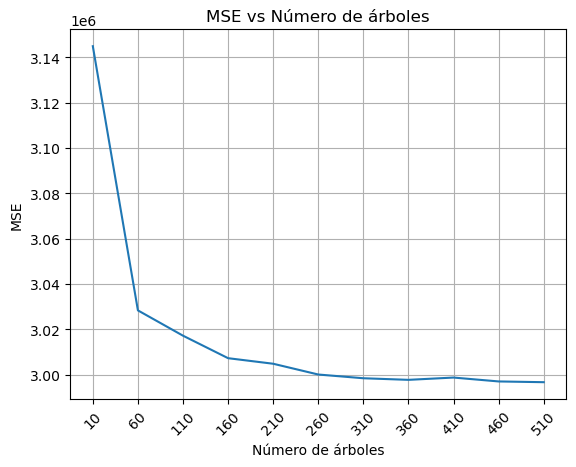

In [23]:
# Gráfica de MSE vs n_estimators
plt.plot(n_estimators,mse_scores_estimatores)
plt.xlabel('Número de árboles')
plt.ylabel('MSE')
plt.title('MSE vs Número de árboles')
plt.xticks(n_estimators,rotation=45)
plt.grid(True)
plt.show()

360 estimadores parece ser una muy buena opción, aunque después de este numero se obtienen mejoras graduales, no es tan sifinificativo el aumento del mse.

In [24]:
rfr=RandomForestRegressor(n_estimators=360,random_state=4,n_jobs=-1)
rfr.fit(X_train,y_train)
# Predicción
y_pred_rfr_estimators=rfr.predict(X_test)
# Evaluación del modelo
mse_rfr_n_estimators=mean_squared_error(y_test,y_pred_rfr_estimators)
rmse_rfr_n_estimators=np.sqrt(mse_rfr_n_estimators)
# MSE del modelo Random Forest con el número óptimo de árboles y variables
print(f'MSE del Random Forest optimizado con estimadores: {mse_rfr_n_estimators:,.0f}')
print(f'RMSE del Random Forest optimizado con estimadores: {rmse_rfr_n_estimators:,.0f}')

MSE del Random Forest optimizado con estimadores: 3,080,171
RMSE del Random Forest optimizado con estimadores: 1,755


#### MAX_FEATURES

In [25]:
feature_range = range(1, X.shape[1]+1)
mse_scores_features = []
for feature in feature_range:
    rfr=RandomForestRegressor(n_estimators=360,max_features=feature,random_state=3,n_jobs=-1)
    mse_scores_features.append(-cross_val_score(rfr,X_train,y_train,cv=5,scoring='neg_mean_squared_error').mean())

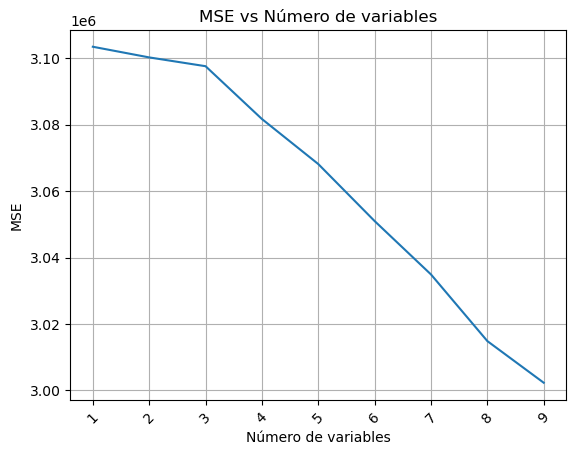

In [26]:
# Gráfica de MSE vs n_estimators
plt.plot(feature_range,mse_scores_features)
plt.xlabel('Número de variables')
plt.ylabel('MSE')
plt.title('MSE vs Número de variables')
plt.xticks(feature_range,rotation=45)
plt.grid(True)
plt.show()

In [27]:
rfr=RandomForestRegressor(n_estimators=360,max_features=9,random_state=4,n_jobs=-1)
rfr.fit(X_train,y_train)
# Predicción
y_pred_rfr_features=rfr.predict(X_test)
# Evaluación del modelo
mse_rfr_features=mean_squared_error(y_test,y_pred_rfr_features)
rmse_rfr_features=np.sqrt(mse_rfr_features)
# MSE del modelo Random Forest con el número óptimo de árboles y variables
print(f'MSE del Random Forest optimizado: estimadores y features: {mse_rfr_features:,.0f}')
print(f'RMSE del Random Forest optimizado: estimadores y features: {rmse_rfr_features:,.0f}')

MSE del Random Forest optimizado: estimadores y features: 3,080,171
RMSE del Random Forest optimizado: estimadores y features: 1,755


#### MAX_DEPTH

In [28]:
depths = range(2, 22, 2)
mse_scores_depths = []

for d in depths:
    rfr = RandomForestRegressor(n_estimators=360, max_features=9, max_depth=d, random_state=5, n_jobs=-1)
    mse_scores_depths.append(-cross_val_score(rfr,X_train,y_train,cv=5,scoring='neg_mean_squared_error').mean())

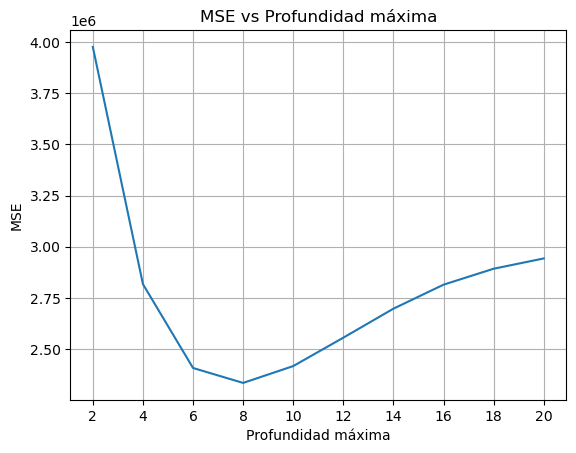

In [29]:
# Gráfica de MSE vs max_depth
plt.plot(depths, mse_scores_depths)
plt.xlabel('Profundidad máxima')
plt.ylabel('MSE')
plt.title('MSE vs Profundidad máxima')
plt.xticks(depths)
plt.grid(True)
plt.show()

In [30]:
# Entrenar el modelo con el número óptimo de árboles y variables
rfr=RandomForestRegressor(n_estimators=360,max_features=9,max_depth=8,random_state=4,n_jobs=-1)
rfr.fit(X_train,y_train)
# Predicción
y_pred_rfr_best=rfr.predict(X_test)
# Evaluación del modelo
mse_rfr_best=mean_squared_error(y_test,y_pred_rfr_best)
rmse_rfr_best=np.sqrt(mse_rfr_best)
# MSE del modelo Random Forest con el número óptimo de árboles y variables
print(f'MSE del Random Forest optimizado:estimadores, features, max_depth {mse_rfr_best:,.0f}')
print(f'RMSE del Random Forest optimizado:estimadores, features, max_depth {rmse_rfr_best:,.0f}')

MSE del Random Forest optimizado:estimadores, features, max_depth 2,452,662
RMSE del Random Forest optimizado:estimadores, features, max_depth 1,566


In [31]:
# Grilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 360],
    'max_depth': [4, 8, 10],
    'max_features': [3, 6, 9]
}
# Modelo Random Forest
rfr = RandomForestRegressor(random_state=7, n_jobs=-1)
# Búsqueda con validación cruzada usando GridSearchCV
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=1)
# Entrenamiento
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=7),
             n_jobs=-1,
             param_grid={'max_depth': [4, 8, 10], 'max_features': [3, 6, 9],
                         'n_estimators': [100, 200, 360]},
             scoring='neg_mean_squared_error', verbose=1)

In [32]:
# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor MSE promedio: {grid_search.best_score_:,.0f}")

Mejores parámetros: {'max_depth': 8, 'max_features': 6, 'n_estimators': 360}
Mejor MSE promedio: -2,308,534


In [33]:
# Modelo final con los mejores hiperparámetros
rfr_final=RandomForestRegressor(n_estimators=360,max_features=6,max_depth=8,random_state=4,n_jobs=-1)
# Entrenamiento
rfr_final.fit(X_train, y_train)
# Predicción
y_pred_final = rfr_final.predict(X_test)
# Evaluación final
mse_rfr_final = mean_squared_error(y_test, y_pred_final)
rmse_rfr_final=np.sqrt(mse_rfr_final)
print(f"MSE Xgbr optimizado: {mse_rfr_final:,.0f}")
print(f"RMSE Xgbr optimizado: {rmse_rfr_final:,.0f}")


MSE Xgbr optimizado: 2,420,308
RMSE Xgbr optimizado: 1,556


| Hiperparámetro | Efecto sobre el modelo | Nota |
|----------------|------------------------|----------------------|
| `n_estimators` | Mayor cantidad de estimaodres mejora el desempeño del modelo aunque no considerablemente. | mejoras leves pero consistentes. |
| `max_features` | Entrenear este parameetro sin contemplar todas las caombinaciones de hiperparámetros arroja resultados locasles | `max_features=6` es el óptimo dado por Grid Search |
| `max_depth`    | Limitar la profunidad ayuda a no tener sobreajuste y obtener mejroes resultados | Este hiperparámetro ayudó a mejorar mucho el resultado del modelo |

El orden de optimización de hiperparámetros puede ser relevante, pero aún más relevante es tener las combinaciones de posibles hiperparámetros, puesto que la optimización local de 1 solo puede no ser la mejor opción para las siguientes iteraciones

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [34]:
# Celda 6
# Modelo básico XGBoost
xgbr = xgb.XGBRegressor(random_state=42, n_jobs=-1)
# Entrenar el modelo
xgbr.fit(X_train,y_train)
# Predicción
y_pred_xgbr=xgbr.predict(X_test)
# Evaluación del modelo
mse_xgbr=mean_squared_error(y_test,y_pred_xgbr)
rmse_xgbr=np.sqrt(mse_xgbr)
# MSE del modelo XGBoost
print(f'MSE del XGBoost: {mse_xgbr:,.0f}')
print(f'RMSE del XGBoost: {rmse_xgbr:,.0f}')

MSE del XGBoost: 2,576,781
RMSE del XGBoost: 1,605


El XGBoost al ir tomando en cuenta los errores de los arboles de forma secuencial obtiene mejores resultados en compración de solo entrenar arboles aleatorios.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [35]:
gamma  = np.arange(0, 3, 0.1)
mse_gama = []

for i in gamma:
    xgbr = xgb.XGBRegressor(gamma=i, n_jobs=-1,n_estimators=500,random_state=2)
    mse_gama.append(-cross_val_score(xgbr,X_train,y_train,
                                             cv=5,scoring='neg_mean_squared_error',
                                             n_jobs=-1).mean())

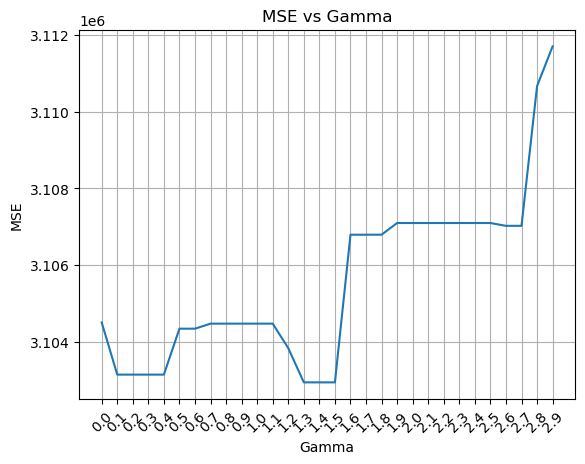

In [36]:
# Gráfica de MSE vs Gamma
plt.plot(gamma, mse_gama)
plt.xlabel('Gamma')
plt.ylabel('MSE')
plt.title('MSE vs Gamma')
plt.xticks(gamma, rotation=45)
plt.grid(True)
plt.show()

In [37]:
xgbr = xgb.XGBRegressor(random_state=42,gamma=1.3, n_jobs=-1,n_estimators=500,randome_state=2)
xgbr.fit(X_train,y_train)
# Predicción
y_pred_xgbr_gamma=xgbr.predict(X_test)
# Evaluación del modelo
mse_xgbr_gamma=mean_squared_error(y_test,y_pred_xgbr_gamma)
rmse_xgbr_gamma=np.sqrt(mse_xgbr_gamma)
# MSE del modelo XGBoost
print(f'MSE del XGBoost optimizado: Gamma {mse_xgbr_gamma:,.0f}')
print(f'RMSE del XGBoost optimizado: Gamma {rmse_xgbr_gamma:,.0f}')

MSE del XGBoost optimizado: Gamma 3,009,120
RMSE del XGBoost optimizado: Gamma 1,735


In [38]:
# Celda 7
learning_rates  = np.arange(0.01, 0.31, 0.01)
mse_learning_rate = []

for i in learning_rates:
    xgbr = xgb.XGBRegressor(learning_rate=i,gamma=1.3, n_jobs=-1,n_estimators=500,random_state=1)
    mse_learning_rate.append(-cross_val_score(xgbr,X_train,y_train,
                                             cv=5,scoring='neg_mean_squared_error',
                                             n_jobs=-1).mean())

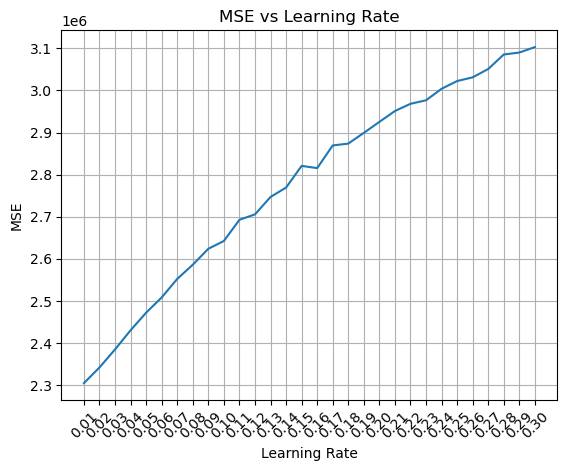

In [39]:
# Gráfica de MSE vs max_depth
plt.plot(learning_rates, mse_learning_rate)
plt.xlabel('Learning Rate')
plt.ylabel('MSE')
plt.title('MSE vs Learning Rate')
plt.xticks(learning_rates, rotation=45)
plt.grid(True)
plt.show()

Parce que al incrementar el Learing Rate, no aprende de forma estable.

In [40]:
xgbr = xgb.XGBRegressor(random_state=42,learning_rate=0.01,gamma=1.3, n_jobs=-1,n_estimators=500,randome_state=2)
xgbr.fit(X_train,y_train)
# Predicción
y_pred_xgbr_lr=xgbr.predict(X_test)
# Evaluación del modelo
mse_xgbr_lr=mean_squared_error(y_test,y_pred_xgbr_lr)
rmse_xgbr_lr=np.sqrt(mse_xgbr_lr)
# MSE del modelo XGBoost
print(f'MSE del XGBoost optimizado: Gamma y Learning Rate {mse_xgbr_lr:,.0f}')
print(f'RMSE del XGBoost optimizado: Gamma y Learning Rate {rmse_xgbr_lr:,.0f}')

MSE del XGBoost optimizado: Gamma y Learning Rate 2,418,948
RMSE del XGBoost optimizado: Gamma y Learning Rate 1,555


In [41]:
colsample  = np.arange(0, 1, 0.1)
mse_colsample = []

for i in colsample:
    xgbr = xgb.XGBRegressor(learning_rate=0.01,gamma=1.3,
                            colsample_bytree=i,
                            n_jobs=-1,n_estimators=500,
                            random_state=2)
    
    mse_colsample.append(-cross_val_score(xgbr,X_train,y_train,
                                             cv=5,scoring='neg_mean_squared_error',
                                             n_jobs=-1).mean())

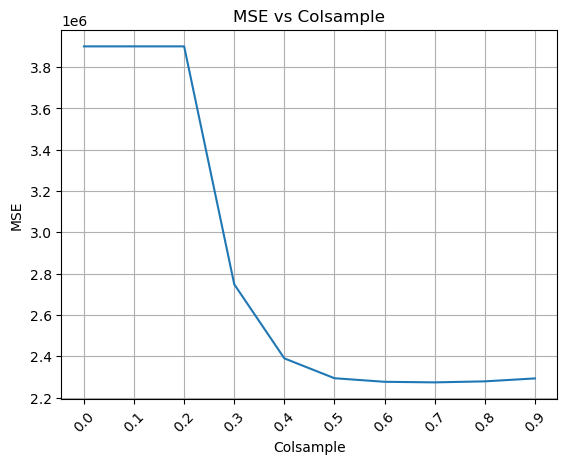

In [42]:
# Gráfica de MSE vs Gamma
plt.plot(colsample, mse_colsample)
plt.xlabel('Colsample')
plt.ylabel('MSE')
plt.title('MSE vs Colsample')
plt.xticks(colsample, rotation=45)
plt.grid(True)
plt.show()

In [43]:
xgbr = xgb.XGBRegressor(random_state=42,learning_rate=0.01,
                        gamma=1.3,colsample_bytree=0.5,
                        n_jobs=-1,n_estimators=500)
xgbr.fit(X_train,y_train)
# Predicción
y_pred_xgbr_colsample=xgbr.predict(X_test)
# Evaluación del modelo
mse_xgbr_colsample=mean_squared_error(y_test,y_pred_xgbr_colsample)
rmse_xgbr_colsample=np.sqrt(mse_xgbr_colsample)
# MSE del modelo XGBoost
print(f'MSE del XGBoost optimizado: Learning Rate, Gamma y colsample {mse_xgbr_colsample:,.0f}')
print(f'RMSE del XGBoost optimizado: Learning Rate, Gamma y colsample {rmse_xgbr_colsample:,.0f}')

MSE del XGBoost optimizado: Learning Rate, Gamma y colsample 2,408,768
RMSE del XGBoost optimizado: Learning Rate, Gamma y colsample 1,552


In [44]:
# Grilla de hiperparámetros
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'gamma': [0.1, 0.5, 1.0, 1.3],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7]
}

# Modelo XGBoost
xgbr = xgb.XGBRegressor(n_estimators=500,random_state=42,n_jobs=-1)

# Búsqueda con validación cruzada usando GridSearchCV
grid_search = GridSearchCV(
    estimator=xgbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores parámetros:", grid_search.best_params_)
print(f"Mejor MSE promedio (CV): {-grid_search.best_score_:,.0f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mejores parámetros: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.01}
Mejor MSE promedio (CV): 2,269,644


In [45]:
# Modelo final con los mejores hiperparámetros
xgbr_final = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.01,
    gamma=0.1,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)
# Entrenamiento
xgbr_final.fit(X_train, y_train)
# Predicción
y_pred_final = xgbr_final.predict(X_test)
# Evaluación final
mse_xgbr_final = mean_squared_error(y_test, y_pred_final)
rmse_xgbr_final=np.sqrt(mse_xgbr_final)
print(f"MSE Xgbr optimizado: {mse_xgbr_final:,.0f}")
print(f"RMSE Xgbr optimizado: {rmse_xgbr_final:,.0f}")

MSE Xgbr optimizado: 2,391,756
RMSE Xgbr optimizado: 1,547


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

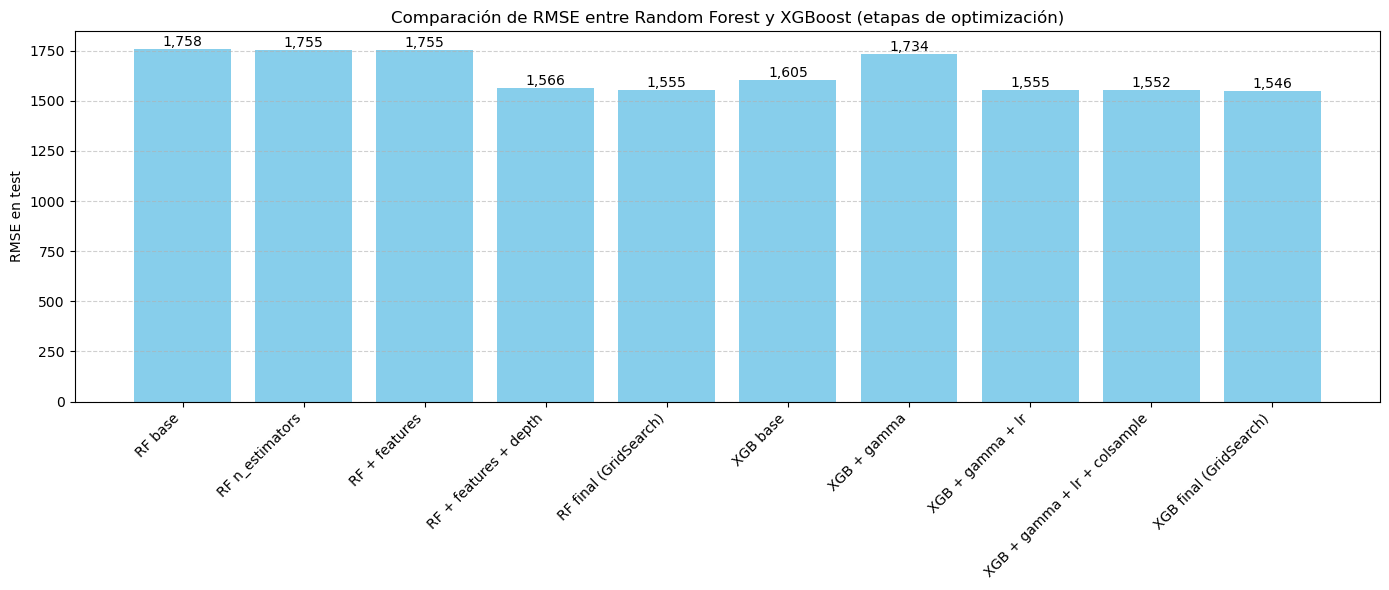

In [50]:
# Nombres de cada versión del modelo
labels = [
    'RF base',
    'RF n_estimators',
    'RF + features',
    'RF + features + depth',
    'RF final (GridSearch)',
    'XGB base',
    'XGB + gamma',
    'XGB + gamma + lr',
    'XGB + gamma + lr + colsample',
    'XGB final (GridSearch)'
]

# Valores correspondientes de RMSE
rmse_values = [
    rmse_rfr,
    rmse_rfr_n_estimators,
    rmse_rfr_features,
    rmse_rfr_best,
    rmse_rfr_final,
    rmse_xgbr,
    rmse_xgbr_gamma,
    rmse_xgbr_lr,
    rmse_xgbr_colsample,
    rmse_xgbr_final
]

# Gráfico de barras
plt.figure(figsize=(14, 6))
bars = plt.bar(labels, rmse_values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE en test')
plt.title('Comparación de RMSE entre Random Forest y XGBoost (etapas de optimización)')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Etiquetar las barras con los valores de MSE
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval , f'{int(yval):,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


| Hiperparámetro        | Efecto sobre el modelo                                                                 | Nota |
|-----------------------|------------------------------------------------------------------------------------------|------|
| `learning_rate`       | Tasa muy alta hace no aprenda bien el modelo. | `learning_rate=0.01` dio el mejor resultado en combinación con otros hiperparámetros. |
| `gamma`               | Un mayor Gamma evita complejidad y ayuda a no tener overfiting | Gamma moderado (`gamma=0.1`) dio el mejor desempeño; gamma alto perjudicó el aprendizaje. |
| `colsample_bytree`    | Controla la cantidad de variables usadas por árbol. Permitir más variables mejora la capacidad del modelo. | `colsample_bytree=0.7` resultó ser el óptimo, mostrando que incluir más variables fue beneficioso. |

El orden de optimización de hiperparámetros puede ser relevante, pero aún más relevante es tener las combinaciones de posibles hiperparámetros, puesto que la optimización local de 1 solo puede no ser la mejor opción para las siguientes iteraciones